In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
colnames = ['pelvic incidence','pelvic tilt','lumbar lordosis angle','sacral slope','pelvic radius','grade of spondylolisthesis', 'class']
data = pd.read_csv('column_2C.dat',sep = ' ', names=colnames, header=None)

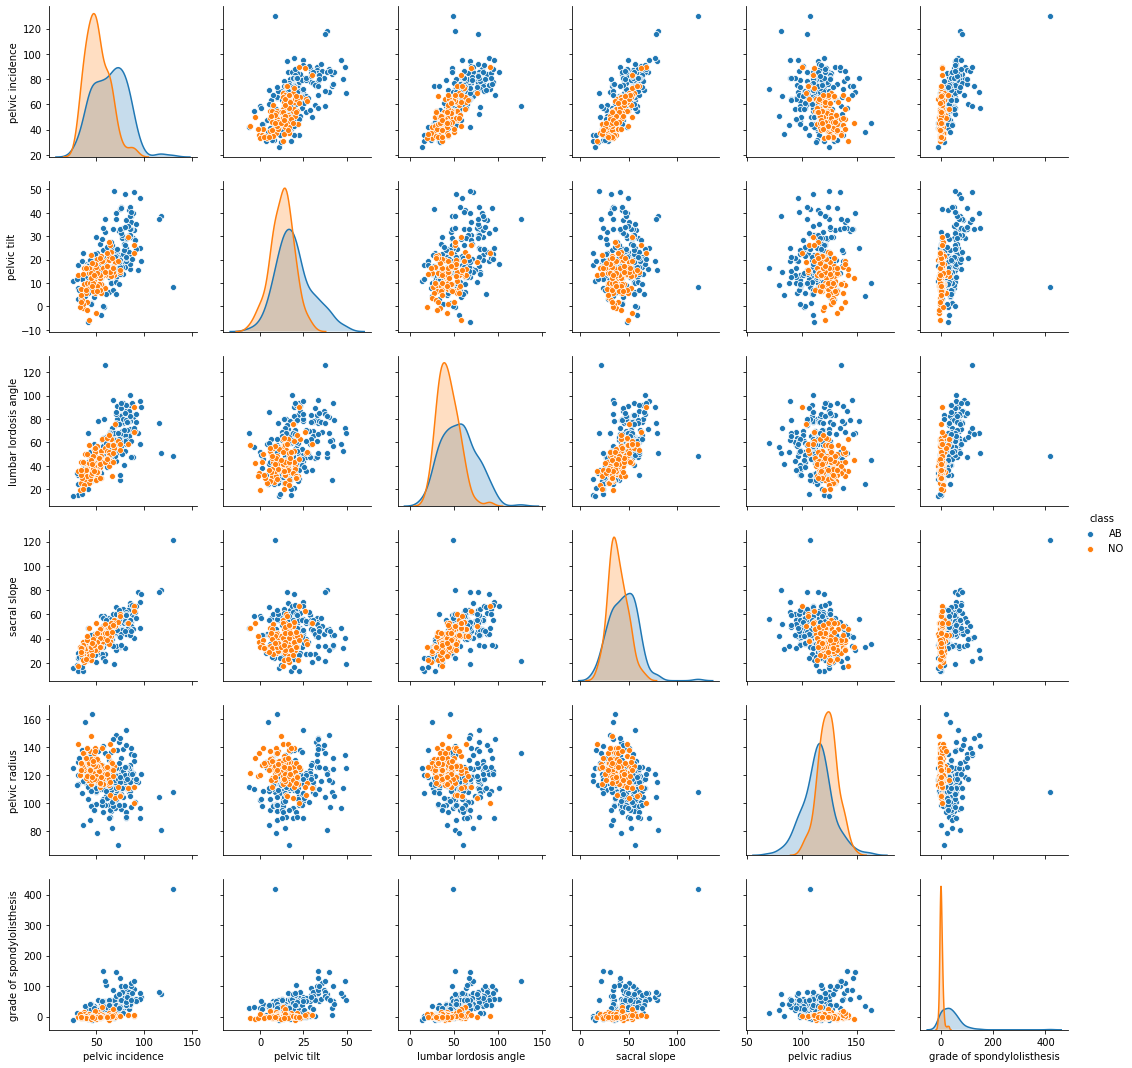

In [3]:
g = sns.pairplot(data, hue='class')

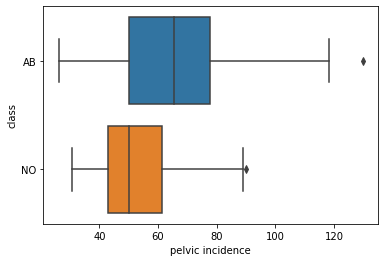

In [4]:
bp1 = sns.boxplot(x="pelvic incidence", y="class", data=data)

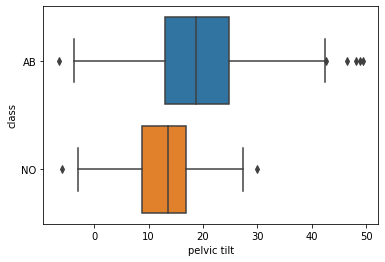

In [5]:
bp2 = sns.boxplot(x="pelvic tilt", y="class", data=data)

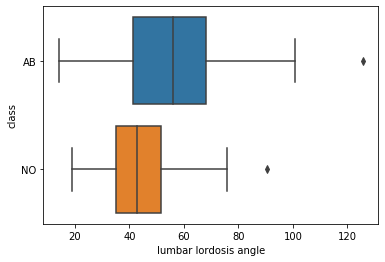

In [6]:
bp3 = sns.boxplot(x="lumbar lordosis angle", y="class", data=data)

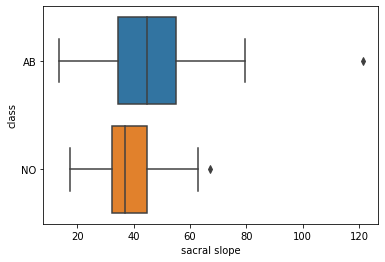

In [7]:
bp4 = sns.boxplot(x="sacral slope", y="class", data=data)

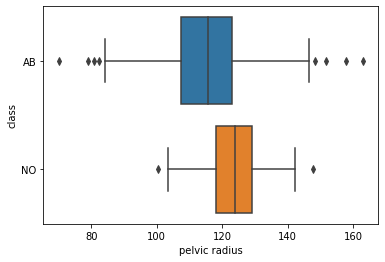

In [8]:
bp5 = sns.boxplot(x="pelvic radius", y="class", data=data)

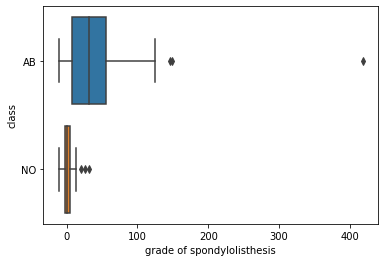

In [9]:
bp6 = sns.boxplot(x="grade of spondylolisthesis", y="class", data=data)

In [10]:
data['flag'] = data.apply(lambda x: 0 if x['class'] == 'NO' else 1, axis=1)
data.columns = ['pelvic incidence','pelvic tilt','lumbar lordosis angle','sacral slope','pelvic radius','grade of spondylolisthesis', 'class' , 'flag']

grouped_AB_Train = data.groupby('class').get_group("AB").reset_index(drop=True).head(140)
grouped_AB_Test = data.groupby('class').get_group("AB").reset_index(drop=True).iloc[140:,:]
grouped_NO_Train = data.groupby('class').get_group("NO").reset_index(drop=True).head(70)
grouped_NO_Test = data.groupby('class').get_group("NO").reset_index(drop=True).iloc[70:,:]

grouped_Train = grouped_AB_Train.append(grouped_NO_Train).reset_index(drop=True)
grouped_Test = grouped_AB_Test.append(grouped_NO_Test).reset_index(drop=True)
# grouped_Train = pd.concat([grouped_NO_Train,grouped_AB_Train], axis=0).reset_index(drop=True)
# grouped_Test = pd.concat([grouped_NO_Test,grouped_AB_Test], axis=0).reset_index(drop=True)

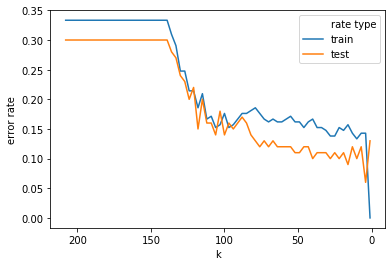

In [11]:
import sklearn as sl
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import neighbors
from sklearn.metrics.classification import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

min_train_error_list = []

x_train = grouped_Train.iloc[:,0:6]
x_test = grouped_Test.iloc[:,0:6]
y_train = grouped_Train.iloc[:,7].values
y_test = grouped_Test.iloc[:,7].values

error_rate_train = []
error_rate_test = []

k_list = list(range(1,209,3))

for k in k_list:
    clf = neighbors.KNeighborsClassifier(k,  metric = "euclidean")
    medical_clf = clf.fit(x_train, y_train)
    train_y_predict = medical_clf.predict(x_train)
    test_y_predict = medical_clf.predict(x_test)
    error_rate_train.append(1 - metrics.classification_report(train_y_predict, y_train, output_dict = True).get('accuracy'))
    error_rate_test.append(1 - metrics.classification_report(test_y_predict, y_test, output_dict = True).get('accuracy'))


min_train_error_list.append({'Distance': 'Euclidean' ,
                                 'Error Rate': min(error_rate_train)}
                           ) 

error_set_train = {'k': k_list , 'error rate': error_rate_train, 'rate type': ['train']*len(k_list) }
error_set_test = {'k': k_list , 'error rate': error_rate_test, 'rate type': ['test']*len(k_list) }
error_data_train = pd.DataFrame(error_set_train)
error_data_test = pd.DataFrame(error_set_test)
error_set = error_data_train.append(error_data_test)



error_rate_plot = sns.lineplot(y="error rate", x="k", hue='rate type', data=error_set).invert_xaxis()

Most suitable k among those k values is 4, the error rate is 0.060000


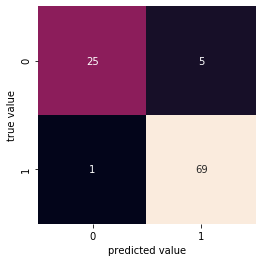

the true positive rate is: 0.985714
the true nagative rate is: 0.833333
the precision is: 0.932432
the f_score is: 0.958333


In [12]:
best_k = error_data_test[error_data_test['error rate'] == error_data_test['error rate'].min()]

print("Most suitable k among those k values is %d, the error rate is %f"%(best_k.k, best_k.get('error rate')))

bkclf = neighbors.KNeighborsClassifier(int(best_k.k),  metric = "euclidean")
bestk_clf = bkclf.fit(x_train, y_train)
y_predict = bestk_clf.predict(x_test)

mat = confusion_matrix(y_test,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()

true_positive_rate = tp / (tp + fn)
true_negative_rate = tn / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2* ((precision * recall) / (precision + recall))

sns.heatmap(mat,square= True, annot=True, cbar= False)
plt.xlabel("predicted value")
plt.ylabel("true value")
plt.show()

print("the true positive rate is: %f"%true_positive_rate)
print("the true nagative rate is: %f"%true_negative_rate)
print("the precision is: %f"%precision)
print("the f_score is: %f"%f_score)



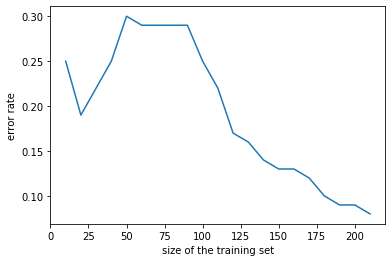

In [13]:
n_list = list(range(10,211,10))
error_min_list = []
for n in n_list:
    no_num = round(n/3)
    ab_num = n - no_num
    grouped_Train_c3 = grouped_AB_Train.head(ab_num).append(grouped_NO_Train.head(no_num)).reset_index(drop=True)
    x_ntrain = grouped_Train_c3.iloc[:,0:6]
    y_ntrain = grouped_Train_c3.iloc[:,7].values
    k_nlist = list(range(1,n,5))
    minimum_error_rate = 100.0
    for k in k_nlist:
    
        clf = neighbors.KNeighborsClassifier(k,  metric = "euclidean")
        medical_clf = clf.fit(x_ntrain, y_ntrain)
        train_y_predict = medical_clf.predict(x_ntrain)
        test_y_predict = medical_clf.predict(x_test)
        
        if minimum_error_rate == 100.0:
            minimum_error_rate = 1 - metrics.classification_report(test_y_predict, y_test, output_dict = True).get('accuracy')
        elif (1 - metrics.classification_report(test_y_predict, y_test, output_dict = True).get('accuracy')) < minimum_error_rate:
            minimum_error_rate = 1 - metrics.classification_report(test_y_predict, y_test, output_dict = True).get('accuracy')
      
    error_min_list.append(minimum_error_rate)
    
error_set_ntest = {'size of the training set': n_list , 'error rate': error_min_list}
error_data_ntest = pd.DataFrame(error_set_ntest)
error_rate_nplot = sns.lineplot(y="error rate", x="size of the training set", data=error_data_ntest)



(d)i. Minkowski Distance:
A. which becomes Manhattan Distance with p = 1.

In [14]:
d_dict = []

In [15]:
error_rate_test_da = []
error_rate_train_da = []
best_k_da = 0

k_list = list(range(1,197,5))

for k in k_list:
    clf = neighbors.KNeighborsClassifier(k,  metric = "manhattan")
    medical_clf = clf.fit(x_train, y_train)
    train_y_predict = medical_clf.predict(x_train)
    test_y_predict = medical_clf.predict(x_test)
    error_rate_train_da.append(1 - metrics.classification_report(train_y_predict, y_train, output_dict = True).get('accuracy'))
    error_rate_test_da.append({'k':k,'error_rate' : 1 - metrics.classification_report(test_y_predict, y_test, output_dict = True).get('accuracy')})


error_rate_test_da_list = [x['error_rate'] for x in error_rate_test_da]
min_test_error_rate_da = min(error_rate_test_da_list)
for item in error_rate_test_da:
    if item['error_rate'] == min_test_error_rate_da:
        best_k_da = item['k']

min_train_error_list.append({'Distance': 'Manhattan' ,
                                 'Error Rate': min(error_rate_train_da)}
                           )         

d_dict.append({'Distance':'Manhattan','K': best_k_da, 'Error Rate': min_test_error_rate_da})
# print(d_dict)
print({'Distance':'Manhattan','K': best_k_da, 'Error Rate': min_test_error_rate_da})


{'Distance': 'Manhattan', 'K': 26, 'Error Rate': 0.10999999999999999}


(d)i. Minkowski Distance:
B. with log10(p) ∈ {0.1,0.2,0.3,...,1}. 

In [16]:
error_rate_train_db = []
error_rate_test_db = []
best_k_db = 0

v_list = np.linspace(0.1,1,10)

for v in v_list:
    clf = neighbors.KNeighborsClassifier(26, algorithm = 'brute', p = 10**v, metric ='minkowski')
    medical_clf = clf.fit(x_train, y_train)
    train_y_predict = medical_clf.predict(x_train)
    test_y_predict = medical_clf.predict(x_test)
    error_rate_train_db.append(1 - metrics.classification_report(train_y_predict, y_train, output_dict = True).get('accuracy'))
    error_rate_test_db.append({'v':v,'error_rate' : 1 - metrics.classification_report(test_y_predict, y_test, output_dict = True).get('accuracy')})

error_rate_test_db_list = [x['error_rate'] for x in error_rate_test_db]
min_test_error_rate_db = min(error_rate_test_db_list)
for item in error_rate_test_db:
    if item['error_rate'] == min_test_error_rate_db:
        best_v_db = item['v']
        
min_train_error_list.append({'Distance': 'Minkowski' ,
                                 'Error Rate': min(error_rate_train_db)}
                           ) 

d_dict.append({'Distance':'Minkowski','K': 26, 'Error Rate': min_test_error_rate_db})
# print(d_dict)
print({'Distance':'Minkowski','K': 26, 'Error Rate': min_test_error_rate_db})



{'Distance': 'Minkowski', 'K': 26, 'Error Rate': 0.09999999999999998}


(d)i. Minkowski Distance:
C. which becomes Chebyshev Distance with p → ∞

In [17]:
error_rate_test_dc = []
error_rate_train_dc = []
best_k_dc = 0

k_list = list(range(1,197,5))

for k in k_list:
    clf = neighbors.KNeighborsClassifier(k,  metric = "chebyshev")
    medical_clf = clf.fit(x_train, y_train)
    train_y_predict = medical_clf.predict(x_train)
    test_y_predict = medical_clf.predict(x_test)
    error_rate_train_dc.append(1 - metrics.classification_report(train_y_predict, y_train, output_dict = True).get('accuracy'))
    error_rate_test_dc.append({'k':k,'error_rate' : 1 - metrics.classification_report(test_y_predict, y_test, output_dict = True).get('accuracy')})

error_rate_test_dc_list = [x['error_rate'] for x in error_rate_test_dc]
min_test_error_rate_dc = min(error_rate_test_dc_list)
for item in error_rate_test_dc:
    if item['error_rate'] == min_test_error_rate_dc:
        best_k_dc = item['k']
        
min_train_error_list.append({'Distance': 'Chebyshev' ,
                                 'Error Rate': min(error_rate_train_dc)}
                           ) 

d_dict.append({'Distance':'Chebyshev','K': best_k_dc, 'Error Rate': min_test_error_rate_dc})
# print(d_dict)
print({'Distance':'Chebyshev','K': best_k_dc, 'Error Rate': min_test_error_rate_dc})


{'Distance': 'Chebyshev', 'K': 16, 'Error Rate': 0.07999999999999996}


ii Mahalanobis Distance

In [18]:
error_rate_test_dii = []
error_rate_train_dii = []

best_k_dii = 0

k_list = list(range(1,197,5))

for k in k_list:
    clf = neighbors.KNeighborsClassifier(k, algorithm='brute', metric ='mahalanobis', metric_params={'V': np.cov(x_train)})
    medical_clf = clf.fit(x_train, y_train)
    train_y_predict = medical_clf.predict(x_train)
    test_y_predict = medical_clf.predict(x_test)
    error_rate_train_dii.append(1 - metrics.classification_report(train_y_predict, y_train, output_dict = True).get('accuracy'))
    error_rate_test_dii.append({'k':k,'error_rate' : 1 - metrics.classification_report(test_y_predict, y_test, output_dict = True).get('accuracy')})

error_rate_test_dii_list = [x['error_rate'] for x in error_rate_test_dii]
min_test_error_rate_dii = min(error_rate_test_dii_list)
for item in error_rate_test_dii:
    if item['error_rate'] == min_test_error_rate_dii:
        best_k_dii = item['k']
        
min_train_error_list.append({'Distance': 'Mahalanobis' ,
                                 'Error Rate': min(error_rate_train_dii)}
                           ) 

d_dict.append({'Distance':'Mahalanobis','K': best_k_dii, 'Error Rate': min_test_error_rate_dii})
# print(d_dict)
print({'Distance':'Mahalanobis','K': best_k_dii, 'Error Rate': min_test_error_rate_dii})


{'Distance': 'Mahalanobis', 'K': 6, 'Error Rate': 0.16000000000000003}


In [19]:
def printTable(myDict, colList=None):
  
   if not colList: colList = list(myDict[0].keys() if myDict else [])
   myList = [colList] # 1st row = header
   for item in myDict: myList.append([str(item[col] or '') for col in colList])
   colSize = [max(map(len,col)) for col in zip(*myList)]
   formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
   myList.insert(1, ['-' * i for i in colSize]) 
   for item in myList: print(formatStr.format(*item))

# d_dict = list(filter(lambda i: i['K'] != 6, d_dict)) 
printTable(d_dict)


Distance    | K  | Error Rate         
----------- | -- | -------------------
Manhattan   | 26 | 0.10999999999999999
Minkowski   | 26 | 0.09999999999999998
Chebyshev   | 16 | 0.07999999999999996
Mahalanobis | 6  | 0.16000000000000003


(e)Euclidean

In [20]:
e_dict = []

In [21]:
error_rate_test_ea = []
error_rate_train_ea = []
best_k_ea = 0

k_list = list(range(1,197,5))

for k in k_list:
    clf = neighbors.KNeighborsClassifier(k, weights='distance', metric = "euclidean")
    medical_clf = clf.fit(x_train, y_train)
    train_y_predict = medical_clf.predict(x_train)
    test_y_predict = medical_clf.predict(x_test)
    error_rate_train_ea.append(1 - metrics.classification_report(train_y_predict, y_train, output_dict = True).get('accuracy'))
    error_rate_test_ea.append({'k':k,'error_rate' : 1 - metrics.classification_report(test_y_predict, y_test, output_dict = True).get('accuracy')})

error_rate_test_ea_list = [x['error_rate'] for x in error_rate_test_ea]
min_test_error_rate_ea = min(error_rate_test_ea_list)
for item in error_rate_test_ea:
    if item['error_rate'] == min_test_error_rate_ea:
        best_k_ea = item['k']
        
min_train_error_list.append({'Distance': 'Weighted Euclidean' ,
                                 'Error Rate': min(error_rate_train_ea)}
                           ) 


e_dict.append({'Weight Distance':'Euclidean','K': best_k_ea, 'Error Rate': min_test_error_rate_ea})
# print(e_dict)
print({'Weight Distance':'Euclidean','K': best_k_ea, 'Error Rate': min_test_error_rate_ea})


{'Weight Distance': 'Euclidean', 'K': 6, 'Error Rate': 0.09999999999999998}


(e)Manhattan

In [22]:
error_rate_test_eb = []
error_rate_train_eb = []
best_k_eb = 0

k_list = list(range(1,197,5))

for k in k_list:
    clf = neighbors.KNeighborsClassifier(k, weights='distance', metric = "manhattan")
    medical_clf = clf.fit(x_train, y_train)
    train_y_predict = medical_clf.predict(x_train)
    test_y_predict = medical_clf.predict(x_test)
    error_rate_train_eb.append(1 - metrics.classification_report(train_y_predict, y_train, output_dict = True).get('accuracy'))
    error_rate_test_eb.append({'k':k,'error_rate' : 1 - metrics.classification_report(test_y_predict, y_test, output_dict = True).get('accuracy')})

error_rate_test_eb_list = [x['error_rate'] for x in error_rate_test_eb]
min_test_error_rate_eb = min(error_rate_test_eb_list)
for item in error_rate_test_eb:
    if item['error_rate'] == min_test_error_rate_eb:
        best_k_eb = item['k']

min_train_error_list.append({'Distance': 'Weighted Manhattan' ,
                                 'Error Rate': min(error_rate_train_eb)}
                           ) 

e_dict.append({'Weight Distance':'Manhattan','K': best_k_eb, 'Error Rate': min_test_error_rate_eb})
# print(e_dict)
print({'Weight Distance':'Manhattan','K': best_k_eb, 'Error Rate': min_test_error_rate_eb})


{'Weight Distance': 'Manhattan', 'K': 26, 'Error Rate': 0.09999999999999998}


(e)Chebyshev

In [23]:
error_rate_test_ec = []
error_rate_train_ec = []
best_k_ec = 0

k_list = list(range(1,197,5))

for k in k_list:
    clf = neighbors.KNeighborsClassifier(k, weights='distance', metric = "chebyshev")
    medical_clf = clf.fit(x_train, y_train)
    train_y_predict = medical_clf.predict(x_train)
    test_y_predict = medical_clf.predict(x_test)
    error_rate_train_ec.append(1 - metrics.classification_report(train_y_predict, y_train, output_dict = True).get('accuracy'))
    error_rate_test_ec.append({'k':k,'error_rate' : 1 - metrics.classification_report(test_y_predict, y_test, output_dict = True).get('accuracy')})

error_rate_test_ec_list = [x['error_rate'] for x in error_rate_test_ec]
min_test_error_rate_ec = min(error_rate_test_ec_list)
for item in error_rate_test_ec:
    if item['error_rate'] == min_test_error_rate_ec:
        best_k_ec = item['k']

min_train_error_list.append({'Distance': 'Weighted Chebyshev' ,
                                 'Error Rate': min(error_rate_train_ec)}
                           ) 

e_dict.append({'Weight Distance':'Chebyshev','K': best_k_ec, 'Error Rate': min_test_error_rate_ec})
# print(e_dict)
print({'Weight Distance':'Chebyshev','K': best_k_ec, 'Error Rate': min_test_error_rate_ec})


{'Weight Distance': 'Chebyshev', 'K': 61, 'Error Rate': 0.10999999999999999}


In [24]:
printTable(e_dict)

Weight Distance | K  | Error Rate         
--------------- | -- | -------------------
Euclidean       | 6  | 0.09999999999999998
Manhattan       | 26 | 0.09999999999999998
Chebyshev       | 61 | 0.10999999999999999


(f) What is the lowest training error rate you achieved in this homework?

In [25]:
pd.DataFrame.from_dict(min_train_error_list)

,Distance,Error Rate
0,Euclidean,0.000000
1,Manhattan,0.000000
2,Minkowski,0.138095
3,Chebyshev,0.000000
4,Mahalanobis,0.000000
5,Weighted Euclidean,0.000000
6,Weighted Manhattan,0.000000
7,Weighted Chebyshev,0.000000


In [26]:
print("The Lowest Training Error Rate is 0.0")

The Lowest Training Error Rate is 0.0
